# Оптимізація нейронної мережі для вирішення задачі класифікації одягу на датасеті Fashion MNIST

Імпортуємо бібліотеки

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

2024-10-18 00:57:00.157113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Готуємо навчальні та валідаційні дані

In [3]:
# Завантаження датасету
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

# Розділення на навчальну та валідаційну вибірки
x_train = x_train_full[:50000]
y_train = y_train_full[:50000]
x_val = x_train_full[50000:]
y_val = y_train_full[50000:]

# Нормалізація даних
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Перетворення зображень в одномірний вектор
x_train = x_train.reshape(-1, 28*28)
x_val = x_val.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# One-hot encoding міток
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


### Використання різної кількості нейронів на першому прихованому шарі (400, 600, 800, 1200)

In [3]:
def create_model_hidden_units(hidden_units):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(784,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

hidden_units_list = [400, 600, 800, 1200]
histories_task1 = []
results_task1 = []

for units in hidden_units_list:
    name = f"{units} нейронів у першому прихованому шарі"
    print(f"Навчання моделі з {units} нейронами у першому прихованому шарі")
    model = create_model_hidden_units(units)
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=64,
        verbose=0
    )
    histories_task1.append({'name': name, 'history': history})
    final_val_accuracy = history.history['val_accuracy'][-1]
    results_task1.append({
        'Кількість нейронів': units,
        'Валідаційна точність': final_val_accuracy
    })


Навчання моделі з 400 нейронами у першому прихованому шарі


2024-10-17 22:45:50.206792: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-17 22:45:50.207347: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-10-17 22:45:50.371510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-17 22:45:50.375408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4060 Laptop GPU computeCapability: 8.9
coreClock: 2.25GHz coreCount: 24 deviceMemorySize: 7.65GiB deviceMemoryBandwidth: 238.45GiB/s
2024-10-17 22:45:50.375442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-17 22:45:50.376737: I tensorflow/stream_executor/p

Навчання моделі з 600 нейронами у першому прихованому шарі
Навчання моделі з 800 нейронами у першому прихованому шарі
Навчання моделі з 1200 нейронами у першому прихованому шарі


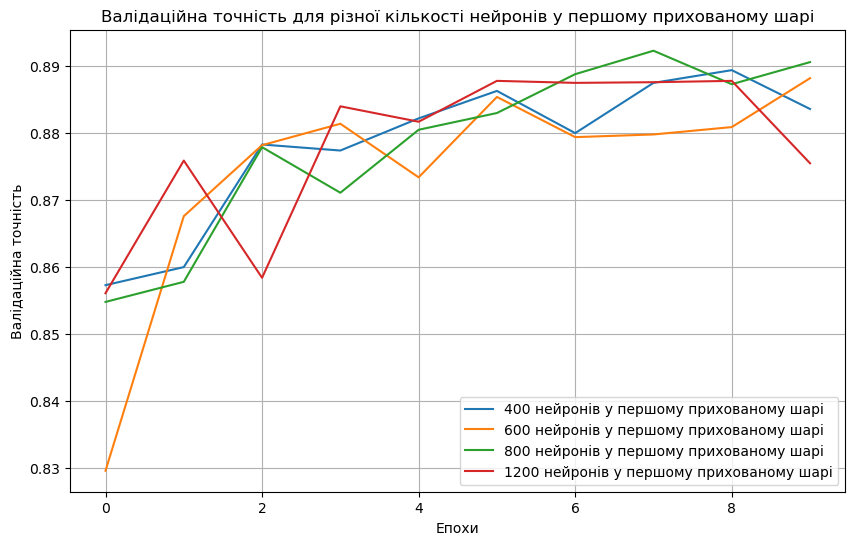

In [6]:
plt.figure(figsize=(10, 6))
for h in histories_task1:
    plt.plot(h['history'].history['val_accuracy'], label=h['name'])
plt.title('Валідаційна точність для різної кількості нейронів у першому прихованому шарі')
plt.xlabel('Епохи')
plt.ylabel('Валідаційна точність')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
results_df = pd.DataFrame(results_task1)
print("Результати завдання 1:")
print(results_df)


Результати завдання 1:
   Кількість нейронів  Валідаційна точність
0                 400                0.8836
1                 600                0.8882
2                 800                0.8906
3                1200                0.8755


Враховуючи отримані результати ми можемо стверджувати, що нейромережа отримала найвищу валідаційну точність (89.06%) при використанні 800 нейронів у прихованому шарі. Збільшення кількості нейронів призводить до перенавчання відповідно і валідаційна точність стає гіршою. Надалі ми будемо використовувати 800 нейронів для першого прихованого шару.

### Додавання прихованого шару з різною кількістю нейронів (200, 300, 400, 600, 800)

In [7]:
def create_model_additional_hidden_layer(hidden_units):
    model = Sequential()
    model.add(Dense(800, activation='relu', input_shape=(784,)))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

hidden_units_list = [200, 300, 400, 600, 800]
histories_task2 = []
results_task2 = []

for units in hidden_units_list:
    name = f"Другий шар: {units} нейронів"
    print(f"Навчання моделі з другим шаром на {units} нейронів")
    model = create_model_additional_hidden_layer(units)
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=64,
        verbose=0
    )
    histories_task2.append({'name': name, 'history': history})
    final_val_accuracy = history.history['val_accuracy'][-1]
    results_task2.append({
        'Нейрони в другому шарі': units,
        'Валідаційна точність': final_val_accuracy
    })

Навчання моделі з другим шаром на 200 нейронів
Навчання моделі з другим шаром на 300 нейронів
Навчання моделі з другим шаром на 400 нейронів
Навчання моделі з другим шаром на 600 нейронів
Навчання моделі з другим шаром на 800 нейронів


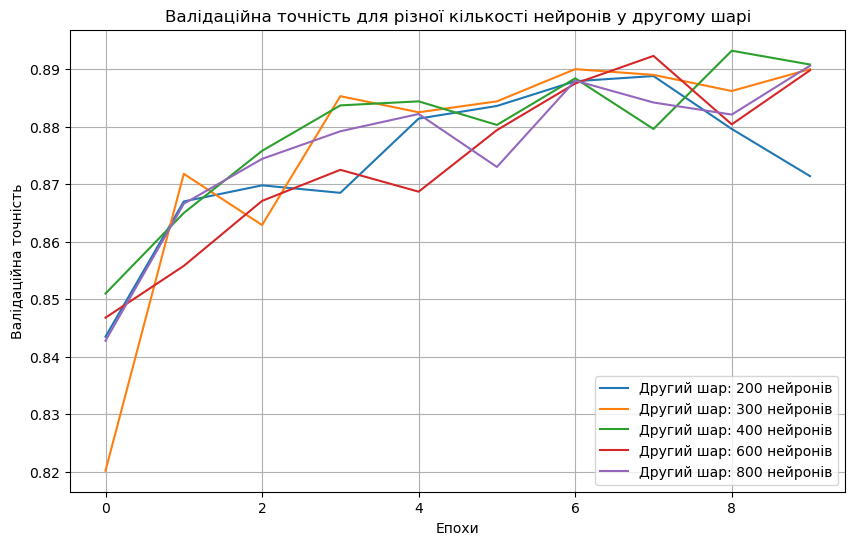

In [8]:
plt.figure(figsize=(10, 6))
for h in histories_task2:
    plt.plot(h['history'].history['val_accuracy'], label=h['name'])
plt.title('Валідаційна точність для різної кількості нейронів у другому шарі')
plt.xlabel('Епохи')
plt.ylabel('Валідаційна точність')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
results_df = pd.DataFrame(results_task2)
print("Результати завдання 2:")
print(results_df)


Результати завдання 2:
   Нейрони в другому шарі  Валідаційна точність
0                     200                0.8714
1                     300                0.8900
2                     400                0.8908
3                     600                0.8898
4                     800                0.8906


Враховуючи отримані результати ми можемо стверджувати, що нейромережа отримала найвищу валідаційну точність (89.08%) при використанні 400 нейронів у другому прихованому шарі. Валідаційна точність не зростає при збільшені кількості нейронів через такі можливі причини:

1. Модель вже має достатню потужність для вивчення залежностей даних і додаткові нейрони не мають сенсу
2. Модель перенавчається
3. Модель через розмір складно оптимізується.

Враховуючи це надалі будемо використовувати 400 нейронів в другому прихованому шарі.

### Додавання додаткових прихованих шарів з різною кількістю нейронів

In [11]:
def create_model_layers(layer_units):
    model = Sequential()
    model.add(Dense(layer_units[0], activation='relu', input_shape=(784,)))
    for units in layer_units[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

layer_configs = [
    [800, 400, 200],
    [800, 400, 200, 100],
    [800, 400, 200, 100, 50],
    [800, 400, 400, 200],
    [800, 400, 300, 200, 100],
]

histories_task3 = []
results_task3 = []

for config in layer_configs:
    name = f"Шари: {config}"
    print(f"Навчання моделі з конфігурацією шарів: {config}")
    model = create_model_layers(config)
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=64,
        verbose=0
    )
    histories_task3.append({'name': name, 'history': history})
    final_val_accuracy = history.history['val_accuracy'][-1]
    results_task3.append({
        'Конфігурація шарів': str(config),
        'Валідаційна точність': final_val_accuracy
    })

Навчання моделі з конфігурацією шарів: [800, 400, 200]
Навчання моделі з конфігурацією шарів: [800, 400, 200, 100]
Навчання моделі з конфігурацією шарів: [800, 400, 200, 100, 50]
Навчання моделі з конфігурацією шарів: [800, 400, 400, 200]
Навчання моделі з конфігурацією шарів: [800, 400, 300, 200, 100]


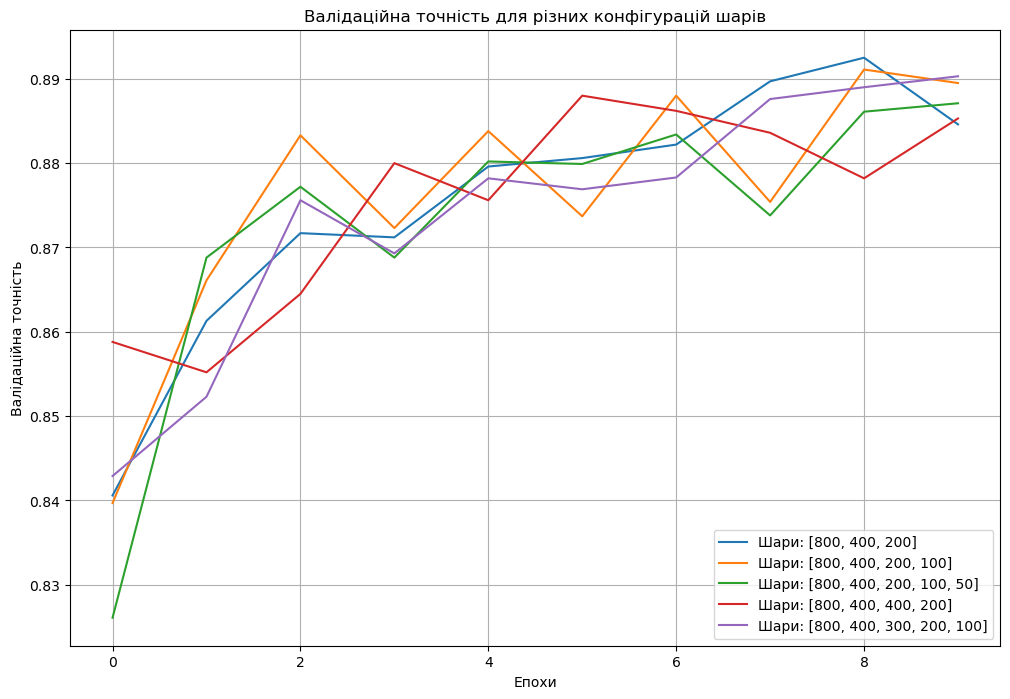

In [12]:
plt.figure(figsize=(12, 8))
for h in histories_task3:
    plt.plot(h['history'].history['val_accuracy'], label=h['name'])
plt.title('Валідаційна точність для різних конфігурацій шарів')
plt.xlabel('Епохи')
plt.ylabel('Валідаційна точність')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
results_df = pd.DataFrame(results_task3)
print("Результати завдання 3:")
print(results_df)

Результати завдання 3:
          Конфігурація шарів  Валідаційна точність
0            [800, 400, 200]                0.8846
1       [800, 400, 200, 100]                0.8895
2   [800, 400, 200, 100, 50]                0.8871
3       [800, 400, 400, 200]                0.8853
4  [800, 400, 300, 200, 100]                0.8903


Враховуючи отримані результати ми можемо стверджувати, що нейромережа отримала найвищу валідаційну точність (89.03%) при використанні конфігурації 800-400-300-200-100 нейронів у прихованих шарах, що дозволило моделі вивчати більш складні та глибокі закономірності. Інші конфігурації не досягли такого успіху через неоптимальне зменшення кількості нейронів у шарах, що призводить до неправильного формування патернів до даних та перенавчання. Незважаючи на те що результат такої конфігурації гірший на 0.05% в порівнянні з конфігурацією 800-400,надалі ми будемо використовувати архітектуру 800-400-300-200-100 і спробуємо досягти оптимізацію за допомогою інших гіперпараметрів.

### Використання різної кількості епох (10, 15, 20, 25, 30)

In [14]:
epochs_list = [10, 15, 20, 25, 30]
histories_task4 = []
results_task4 = []

for epochs in epochs_list:
    name = f"{epochs} епох"
    print(f"Навчання моделі з {epochs} епохами")
    model = Sequential()
    model.add(Dense(800, activation='relu', input_shape=(784,)))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=64,
        verbose=0
    )
    histories_task4.append({'name': name, 'history': history})
    final_val_accuracy = history.history['val_accuracy'][-1]
    results_task4.append({
        'Кількість епох': epochs,
        'Валідаційна точність': final_val_accuracy
    })


Навчання моделі з 10 епохами
Навчання моделі з 15 епохами
Навчання моделі з 20 епохами
Навчання моделі з 25 епохами
Навчання моделі з 30 епохами


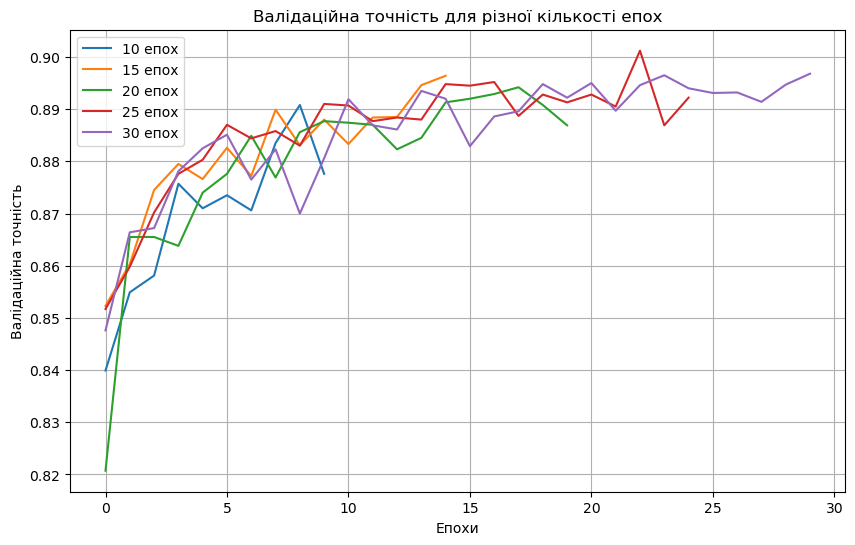

In [15]:
plt.figure(figsize=(10, 6))
for h in histories_task4:
    plt.plot(h['history'].history['val_accuracy'], label=h['name'])
plt.title('Валідаційна точність для різної кількості епох')
plt.xlabel('Епохи')
plt.ylabel('Валідаційна точність')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
results_df = pd.DataFrame(results_task4)
print("Результати завдання 4:")
print(results_df)


Результати завдання 4:
   Кількість епох  Валідаційна точність
0              10                0.8776
1              15                0.8964
2              20                0.8869
3              25                0.8922
4              30                0.8968


Використовуючи отримані дані ми можемо стверджувати що кількість епох навчання покращило валідаційну точність і найкраще значення в 89.68% модель отримує навчаючись протягом 30 епох. Надалі ми будемо використовувати цю кількість епох.

### Використання різних розмірів міні-вибірок (10, 50, 100, 200, 500)

In [17]:
batch_sizes = [10, 50, 100, 200, 500]
histories_task5 = []
results_task5 = []

for batch_size in batch_sizes:
    name = f"Batch size: {batch_size}"
    print(f"Навчання моделі з batch_size = {batch_size}")
    model = Sequential()
    model.add(Dense(800, activation='relu', input_shape=(784,)))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=30,
        batch_size=batch_size,
        verbose=0
    )
    histories_task5.append({'name': name, 'history': history})
    final_val_accuracy = history.history['val_accuracy'][-1]
    results_task5.append({
        'Batch Size': batch_size,
        'Валідаційна точність': final_val_accuracy
    })


Навчання моделі з batch_size = 10
Навчання моделі з batch_size = 50
Навчання моделі з batch_size = 100
Навчання моделі з batch_size = 200
Навчання моделі з batch_size = 500


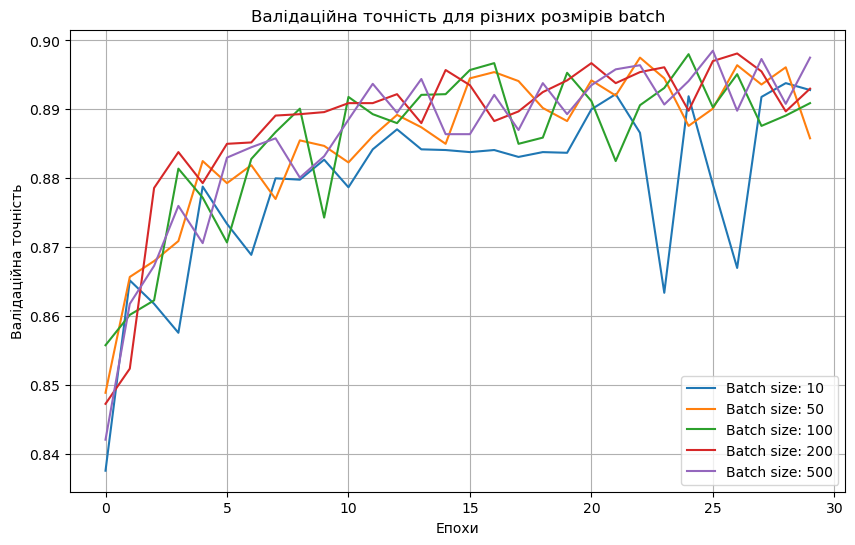

In [18]:
plt.figure(figsize=(10, 6))
for h in histories_task5:
    plt.plot(h['history'].history['val_accuracy'], label=h['name'])
plt.title('Валідаційна точність для різних розмірів batch')
plt.xlabel('Епохи')
plt.ylabel('Валідаційна точність')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
results_df = pd.DataFrame(results_task5)
print("Результати завдання 5:")
print(results_df)


Результати завдання 5:
   Batch Size  Валідаційна точність
0          10                0.8928
1          50                0.8858
2         100                0.8909
3         200                0.8930
4         500                0.8975


Використовуючи отримані дані можемо стведжувати що при збільшені розміру міні вибірок зростає валідаційна точність моделі, оскільки великі батчі надають більш точну оцінку градієнта оскільки при оновлені ваг використовується більша кількість даних. При батчі 500 було досягнуто валідаційну точність 89,75%.

### Використання різних комбінацій гіперпараметрів

In [4]:
configs = [
    {
         'name': 'ReLU + Adam lr=0.001',
         'activation': 'relu',
         'optimizer': Adam(learning_rate=0.001),
         'regularizer': None,
         'dropout': False
    },
    {
         'name': 'ELU + Adam lr=0.001',
         'activation': 'elu',
         'optimizer': Adam(learning_rate=0.001),
         'regularizer': None,
         'dropout': False
    },
    {
         'name': 'ReLU + Adam lr=0.0001',
         'activation': 'relu',
         'optimizer': Adam(learning_rate=0.0001),
         'regularizer': None,
         'dropout': False
    },
    {
         'name': 'ReLU + SGD lr=0.01',
         'activation': 'relu',
         'optimizer': SGD(learning_rate=0.01),
         'regularizer': None,
         'dropout': False
    },
    {
         'name': 'ReLU + Adam lr=0.001 + L2 Reg',
         'activation': 'relu',
         'optimizer': Adam(learning_rate=0.001),
         'regularizer': regularizers.l2(0.001),
         'dropout': False
    },
    {
         'name': 'ReLU + Adam lr=0.001 + Dropout',
         'activation': 'relu',
         'optimizer': Adam(learning_rate=0.001),
         'regularizer': None,
         'dropout': True
    },
    {
        'name': 'Sigmoid + Adam lr=0.001',
        'activation': 'sigmoid',
        'optimizer': Adam(learning_rate=0.001),
        'regularizer': None,
        'dropout': False
    },
    {
        'name': 'ELU + Adam lr=0.001 + Dropout',
        'activation': 'elu',
        'optimizer': Adam(learning_rate=0.001),
        'regularizer': None,
        'dropout': True
    },
]

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

histories_task6 = []
results_task6 = []

for config in configs:
    name = config['name']
    print(f"Навчання моделі: {name}")
    model = Sequential()
    model.add(Dense(800, activation=config['activation'], input_shape=(784,), 
                    kernel_regularizer=config['regularizer']))
    if config['dropout']:
        model.add(Dropout(0.5))
    model.add(Dense(400, activation=config['activation'], kernel_regularizer=config['regularizer']))
    if config['dropout']:
        model.add(Dropout(0.5))
    model.add(Dense(300, activation=config['activation'], kernel_regularizer=config['regularizer']))
    if config['dropout']:
        model.add(Dropout(0.5))
    model.add(Dense(200, activation=config['activation'], kernel_regularizer=config['regularizer']))
    if config['dropout']:
        model.add(Dropout(0.5))
    model.add(Dense(100, activation=config['activation'], kernel_regularizer=config['regularizer']))
    if config['dropout']:
        model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=config['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=30,
        batch_size=500,
        callbacks=[early_stop],
        verbose=0
    )
    histories_task6.append({'name': name, 'history': history})
    final_val_accuracy = history.history['val_accuracy'][-1]
    results_task6.append({
        'Конфігурація': name,
        'Валідаційна точність': final_val_accuracy
    })


Навчання моделі: ReLU + Adam lr=0.001


2024-10-18 00:58:09.817559: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-18 00:58:09.818177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-10-18 00:58:09.948620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-18 00:58:09.952155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4060 Laptop GPU computeCapability: 8.9
coreClock: 2.25GHz coreCount: 24 deviceMemorySize: 7.65GiB deviceMemoryBandwidth: 238.45GiB/s
2024-10-18 00:58:09.952175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-18 00:58:09.953354: I tensorflow/stream_executor/p

Навчання моделі: ELU + Adam lr=0.001
Навчання моделі: ReLU + Adam lr=0.0001
Навчання моделі: ReLU + SGD lr=0.01
Навчання моделі: ReLU + Adam lr=0.001 + L2 Reg
Навчання моделі: ReLU + Adam lr=0.001 + Dropout
Навчання моделі: Sigmoid + Adam lr=0.001
Навчання моделі: ELU + Adam lr=0.001 + Dropout


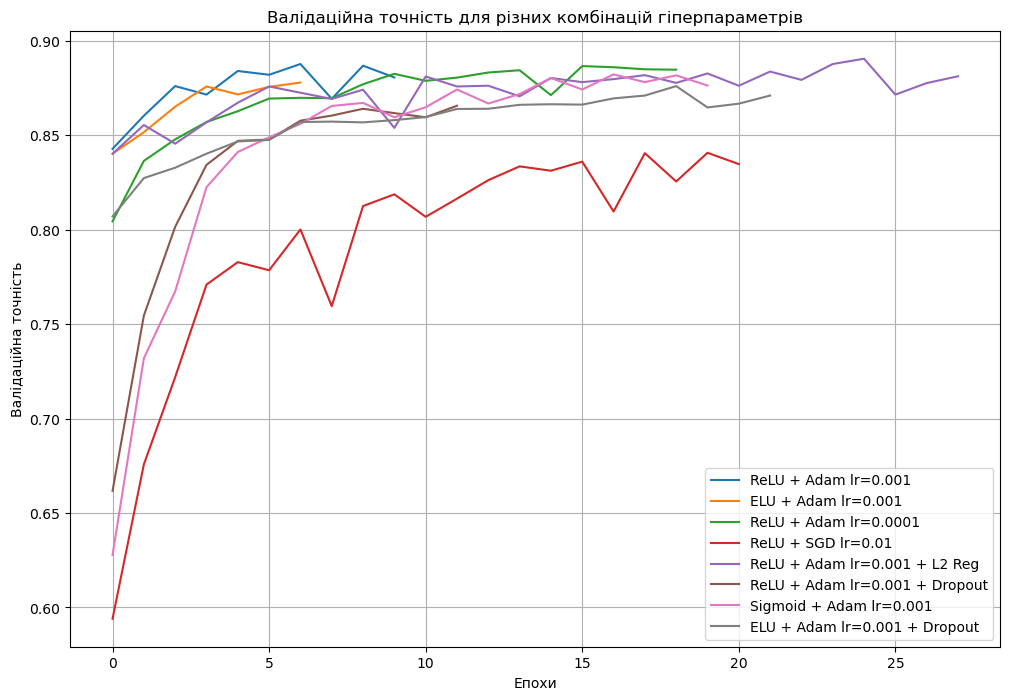

In [5]:
plt.figure(figsize=(12, 8))
for h in histories_task6:
    plt.plot(h['history'].history['val_accuracy'], label=h['name'])
plt.title('Валідаційна точність для різних комбінацій гіперпараметрів')
plt.xlabel('Епохи')
plt.ylabel('Валідаційна точність')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Виведення таблиці результатів
results_df = pd.DataFrame(results_task6)
print("\nРезультати завдання 6:")
print(results_df)



Результати завдання 6:
                     Конфігурація  Валідаційна точність
0            ReLU + Adam lr=0.001                0.8806
1             ELU + Adam lr=0.001                0.8779
2           ReLU + Adam lr=0.0001                0.8847
3              ReLU + SGD lr=0.01                0.8347
4   ReLU + Adam lr=0.001 + L2 Reg                0.8812
5  ReLU + Adam lr=0.001 + Dropout                0.8656
6         Sigmoid + Adam lr=0.001                0.8763
7   ELU + Adam lr=0.001 + Dropout                0.8710


Виходячи з отриманих даних, найкращий результат 88,47% дала звʼязка гіперпараметрів ReLU + Adam lr=0.0001. Валідаційна точність менша ніж за минулі рази, але в цей раз ми робимо зупинку задля уникнення проблем з перенавчанням

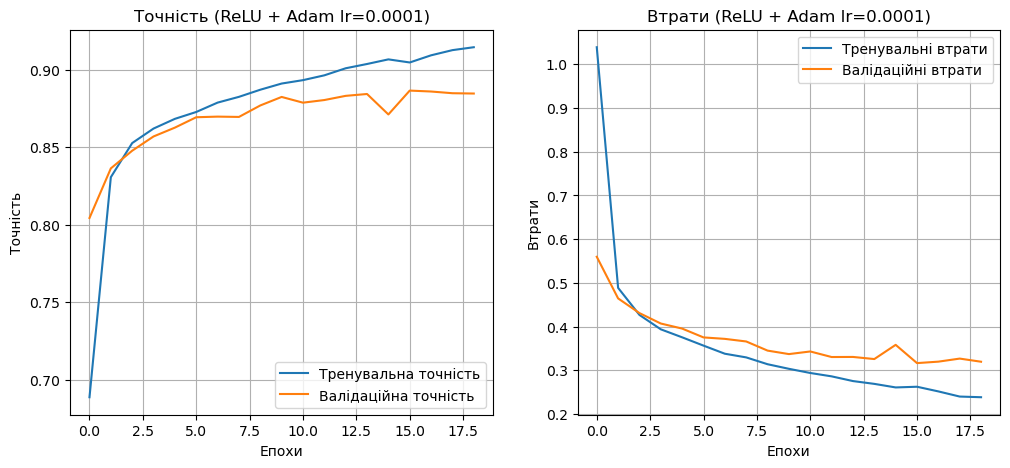

In [8]:
# Знаходимо історію навчання для вибраної моделі
selected_history = None
for h in histories_task6:
    if h['name'] == 'ReLU + Adam lr=0.0001':
        selected_history = h['history']
        break

# Побудова графіків точності та втрат
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(selected_history.history['accuracy'], label='Тренувальна точність')
plt.plot(selected_history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Точність (ReLU + Adam lr=0.0001)')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(selected_history.history['loss'], label='Тренувальні втрати')
plt.plot(selected_history.history['val_loss'], label='Валідаційні втрати')
plt.title('Втрати (ReLU + Adam lr=0.0001)')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Тестова точність: {test_accuracy * 100:.2f}%")


313/313 [==============================] - 0s 1ms/step - loss: 0.3757 - accuracy: 0.8673
Тестова точність: 86.73%


Фінальна модель з оптимізаціями має точність 86,73% що не дуже відрізняється від валідаційної точності і є доволі високим результатом